# Perform Analysis 01 Analysis
The analysis is a 2x7 repeated measures ANOVA comparing ROI hemisphere (left and right) and denoising strategy, with subject as the repeated measure.

If the interaction between hemisphere and denoising method is singificant, the ANOVA is followed up with simple effects tests at each level of hemisphere, because our focus is on denoising strategy. For any simple effects that are significant, we will perform Tukey HSD tests, with a focus on comparisons between different denoising methods and MEDN.

In [2]:
library(multcomp)
library(nlme)
library(tidyverse)

── Attaching packages ─────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.3     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

Warning message:
“package ‘ggplot2’ was built under R version 4.1.2”
Warning message:
“package ‘tidyr’ was built under R version 4.1.2”
Warning message:
“package ‘readr’ was built under R version 4.1.2”
Warning message:
“package ‘dplyr’ was built under R version 4.1.2”
── Conflicts ────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse


Warning message:
“package ‘multcomp’ was built under R version 4.1.2”
Loading required package: mvtnorm

Loading required package: survival

Loading required package: TH.data

Warning message:
“package ‘TH.

In [3]:
df=read_csv("test_data.csv")
df <- within(df, {
  subject <- factor(subject)
  hemisphere <- factor(hemisphere)
  denoising_strategy <- factor(denoising_strategy)
})

Rows: 60 Columns: 4
── Column specification ────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (2): hemisphere, denoising_strategy
dbl (2): subject, cnr

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
head(df)

subject,cnr,hemisphere,denoising_strategy
<fct>,<dbl>,<fct>,<fct>
1,0.8203642,L,A
1,0.7221495,R,A
1,0.8258592,L,B
1,0.5595648,R,B
1,0.4926534,L,C
1,0.6444768,R,C


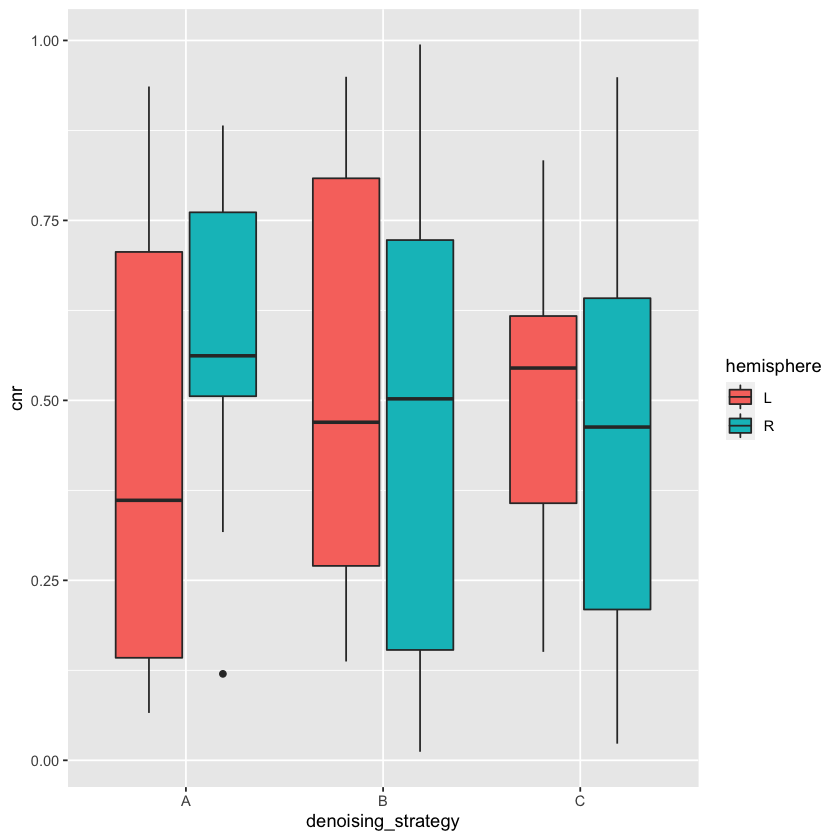

In [5]:
ggplot(df, aes(y=cnr,x=denoising_strategy,fill=hemisphere))+geom_boxplot()

`summarise()` has grouped output by 'denoising_strategy'. You can override using the `.groups`
argument.


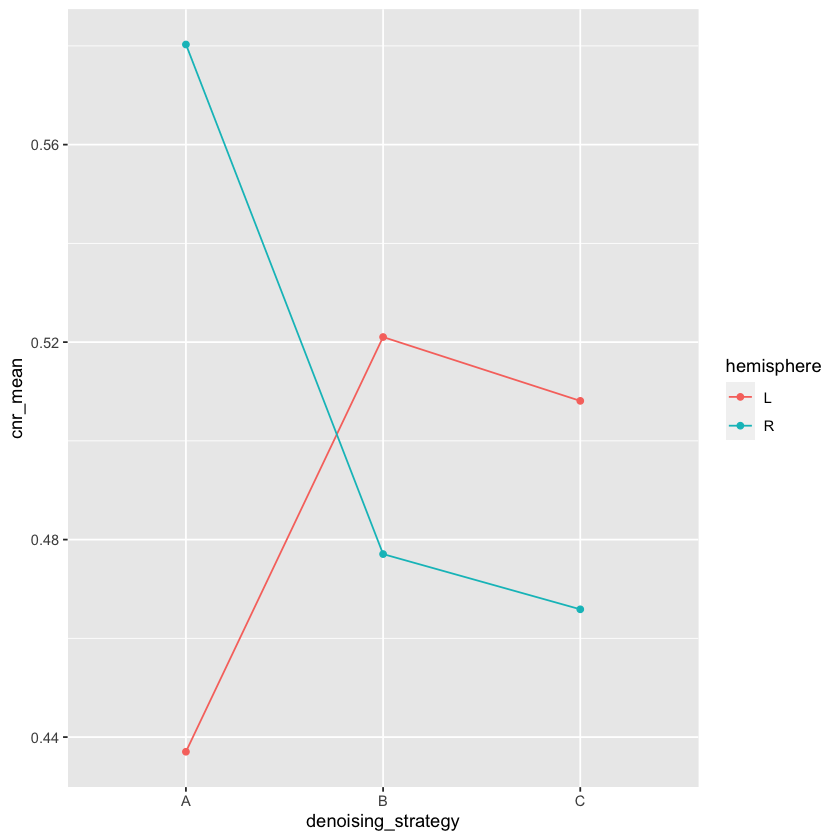

In [17]:
df %>% 
  group_by(denoising_strategy,hemisphere) %>% 
  summarize(cnr_mean=mean(cnr)) %>% 
  ggplot(aes(y=cnr_mean, x=denoising_strategy, colour=hemisphere, group=hemisphere))+
    geom_point()+geom_line()

## Perform 2-Way ANOVA

In [7]:
cnr_anova=aov(cnr~denoising_strategy * hemisphere + Error(subject / (denoising_strategy * hemisphere)), data=df)
summary(cnr_anova)


Error: subject
          Df Sum Sq Mean Sq F value Pr(>F)
Residuals  9 0.6243 0.06937               

Error: subject:denoising_strategy
                   Df Sum Sq Mean Sq F value Pr(>F)
denoising_strategy  2 0.0047 0.00236   0.018  0.982
Residuals          18 2.3920 0.13289               

Error: subject:hemisphere
           Df Sum Sq Mean Sq F value Pr(>F)
hemisphere  1 0.0054 0.00543   0.065  0.805
Residuals   9 0.7543 0.08381               

Error: subject:denoising_strategy:hemisphere
                              Df Sum Sq Mean Sq F value Pr(>F)
denoising_strategy:hemisphere  2 0.1158 0.05788   1.024  0.379
Residuals                     18 1.0179 0.05655               

## Simple Effects Analysis

Investigate the simple effect of denoising strategy at each level of hemisphere.

### Simple effect of denoising strategy for the left hemisphere

In [8]:
df %>% filter(hemisphere=="L") %>% 
  aov(cnr~denoising_strategy+Error(subject / denoising_strategy),data=.) %>% 
  summary()


Error: subject
          Df Sum Sq Mean Sq F value Pr(>F)
Residuals  9  0.468   0.052               

Error: subject:denoising_strategy
                   Df Sum Sq Mean Sq F value Pr(>F)
denoising_strategy  2 0.0409 0.02046   0.206  0.815
Residuals          18 1.7852 0.09918               

### Simple effect of denoising strategy for the right hemisphere

In [9]:
df %>% filter(hemisphere=="R") %>% 
  aov(cnr~denoising_strategy+Error(subject / denoising_strategy),data=.) %>% 
  summary()


Error: subject
          Df Sum Sq Mean Sq F value Pr(>F)
Residuals  9 0.9106  0.1012               

Error: subject:denoising_strategy
                   Df Sum Sq Mean Sq F value Pr(>F)
denoising_strategy  2 0.0796 0.03978   0.441   0.65
Residuals          18 1.6247 0.09026               

### Tukey post-hoc tests

### Tukey HSD tests on right hemisphere
We start by reproducing the simple effects analysis with `lme`, then we feed that to `glht` and `mcp` for _post hoc_ test.

In [10]:
df_r_hemi = df %>% filter(hemisphere=="R")

lme_hemi_r = lme(cnr ~ denoising_strategy, data=df_r_hemi, random=~1|subject)
anova(lme_hemi_r)

,numDF,denDF,F-value,p-value
,<int>,<dbl>,<dbl>,<dbl>
(Intercept),1,18,76.4378652,6.766211e-08
denoising_strategy,2,18,0.4406915,6.503518e-01


In [11]:
summary(glht(lme_hemi_r, linfct=mcp(denoising_strategy="Tukey")), test=adjusted(type="bonferroni"))


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lme.formula(fixed = cnr ~ denoising_strategy, data = df_r_hemi, 
    random = ~1 | subject)

Linear Hypotheses:
           Estimate Std. Error z value Pr(>|z|)
B - A == 0 -0.10322    0.13436  -0.768        1
C - A == 0 -0.11440    0.13436  -0.851        1
C - B == 0 -0.01118    0.13436  -0.083        1
(Adjusted p values reported -- bonferroni method)


### Tukey HSD tests on left hemisphere
We start by reproducing the simple effects analysis with `lme`, then we feed that to `glht` and `mcp` for _post hoc_ test.

In [12]:
df_l_hemi = df %>% filter(hemisphere=="L")

lme_hemi_l = lme(cnr ~ denoising_strategy, data=df_l_hemi, random=~1|subject)
anova(lme_hemi_l)

,numDF,denDF,F-value,p-value
,<int>,<dbl>,<dbl>,<dbl>
(Intercept),1,18,85.8613672,2.847863e-08
denoising_strategy,2,18,0.2451512,7.851568e-01


In [13]:
summary(glht(lme_hemi_l, linfct=mcp(denoising_strategy="Tukey")), test=adjusted(type="bonferroni"))


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lme.formula(fixed = cnr ~ denoising_strategy, data = df_l_hemi, 
    random = ~1 | subject)

Linear Hypotheses:
           Estimate Std. Error z value Pr(>|z|)
B - A == 0  0.08400    0.12919    0.65        1
C - A == 0  0.07107    0.12919    0.55        1
C - B == 0 -0.01293    0.12919   -0.10        1
(Adjusted p values reported -- bonferroni method)
